In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from gensim.models import KeyedVectors
# This notebook feeds the spam SMS corpus into word2vec and trains
# logistic regression on the 300-dimensional vector resulting from
# word2vec embedding.

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} numpy matplotlib pandas nltk word2vec gensim


[+] 0.0s
[+] 0.1s
pkgs/main/osx-64   ━━━━━╸━━━━━━━━━━━━━━━╸━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/main/noarch   ━━━━━━━━╸━━━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/r/osx-64      ━━━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
pkgs/r/noarch      ━━━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
conda-forge/osx-64 ━━━━━━━━━╸━━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.2s
pkgs/main/noarch   ━━━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.2s
pkgs/r/osx-64      ━━━━━━━━━━━━━━╸━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.2s
pkgs/r/noarch      ━━━━━━━━━━━━╸━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.2s
conda-forge/osx-64 ━━━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.2s
conda-forge/noarch ━━━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0spkgs/main/osx-64                                              No change
pkgs/r/noarch                                                 No change
pkgs/r/osx-64        

In [5]:
! conda env list

# conda environments:
#
base                  *  /Users/wltrimbl/miniconda3
R                        /Users/wltrimbl/miniconda3/envs/R
quarto                   /Users/wltrimbl/miniconda3/envs/quarto
r                        /Users/wltrimbl/miniconda3/envs/r
scipy                    /Users/wltrimbl/miniconda3/envs/scipy
termcolor                /Users/wltrimbl/miniconda3/envs/termcolor
tf                       /Users/wltrimbl/miniconda3/envs/tf
tf2                      /Users/wltrimbl/miniconda3/envs/tf2
w2v                      /Users/wltrimbl/miniconda3/envs/w2v



In [6]:
!conda list | grep numpy

numpy                     1.23.5          py310h9638375_0  
numpy-base                1.23.5          py310ha98c3c9_0  


In [7]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [8]:
wv = gensim.downloader.load('word2vec-google-news-300')

In [9]:
# Okay, this demo has wv.most_similar.. which takes a "positive" and a "negative" list of words
# https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
print(wv.most_similar(positive=['mushroom'], topn=5))

[('mushrooms', 0.7716438174247742), ('chanterelle', 0.6103289127349854), ('wild_mushrooms', 0.6075051426887512), ('oyster_mushrooms', 0.5885806083679199), ('morels', 0.584884762763977)]


In [10]:
print(wv.most_similar(positive=['mushroom', "onion", "garlic", "tofu"], topn=5))

[('onions', 0.7788934707641602), ('cauliflower', 0.7541464567184448), ('mushrooms', 0.7501453161239624), ('cabbage', 0.7384436726570129), ('eggplant', 0.7381553649902344)]


In [11]:
print(wv.most_similar(positive=['mushroom', "onion", "garlic", "chicken"], topn=5))

[('onions', 0.7950847744941711), ('tomato', 0.7402370572090149), ('mushrooms', 0.7371248602867126), ('cauliflower', 0.733453631401062), ('cabbage', 0.723550021648407)]


In [12]:
print(wv.most_similar(positive=['dropout', "invest"], negative=["graduate"], topn=5))

[('investing', 0.5440436005592346), ('invested', 0.48033177852630615), ('invests', 0.4520416259765625), ('investment', 0.44751736521720886), ('reinvest', 0.441010057926178)]


In [13]:
# Okay, Cookie, which one of these things is not like the others?
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


In [14]:
# https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import KeyedVectors

In [15]:
vector = wv['computer']  # Get word2vec number for a word 
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  4.,  6.,  6.,  7., 10., 17., 18.,
        22., 21., 29., 19., 29., 31., 14., 10., 12., 18., 12.,  3.,  4.,
         1.,  1.,  1.,  2.]),
 array([-0.53515625, -0.50325519, -0.47135416, -0.43945312, -0.40755209,
        -0.37565103, -0.34375   , -0.31184897, -0.27994791, -0.24804688,
        -0.21614583, -0.1842448 , -0.15234375, -0.12044271, -0.08854166,
        -0.05664062, -0.02473958,  0.00716146,  0.0390625 ,  0.07096354,
         0.10286459,  0.13476562,  0.16666667,  0.1985677 ,  0.23046875,
         0.26236978,  0.29427084,  0.32617188,  0.35807291,  0.38997397,
         0.421875  ]),
 <BarContainer object of 30 artists>)

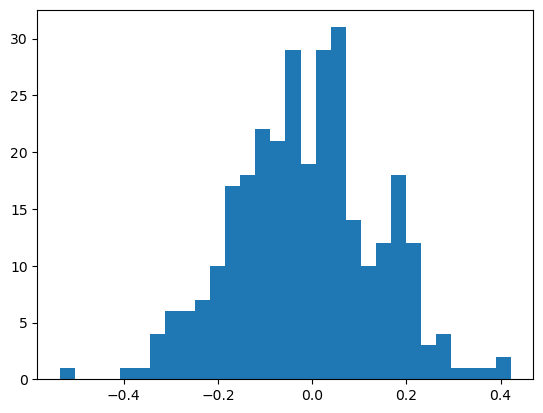

In [16]:
plt.hist(vector, bins=30)

In [20]:
# Are these vectors normalized?
np.sum( np.dot ( vector, vector) ) 

6.927437

In [23]:
spam =pd.read_csv("../data/spam.csv", encoding="latin-1")
spamclean = []
for line in open("../data/spam.csv", encoding="latin-1"):
        a = line.find(",")
        spamclean.append((line[0:a], line[a+1:]))
spam = pd.DataFrame(spamclean)
spam = spam.drop(labels=0, axis=0)  #only do this once
spam =spam.rename({0: "label", 1:"text"}, axis=1)

In [24]:
ind = np.argsort(np.random.random(len(spam)))
spam_test = spam.iloc[ind[0:450],:] 
spam_train = spam.iloc[ind[450:],:] 

In [25]:
Ytrain = spam_train.loc[:,"label"] == "spam" 
Xtrain = spam_train.loc[:,"text"]
Ytest = spam_test.loc[:,"label"] == "spam" 
Xtest = spam_test.loc[:,"text"]

In [26]:
Y = np.array(Ytrain)

In [27]:
Xtrain.iloc[0]

"Can't. I feel nauseous. I'm so pissed. I didn't eat any sweets all week cause today I was planning to pig out. I was dieting all week. And now I'm not hungry :/,,,\n"

In [149]:
def string_to_vec(s):
    tok1 = nltk.word_tokenize(s)
    print(dir(tok1))


In [30]:
string_to_vec(Xtext.iloc[0])

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [150]:
tokens =nltk.word_tokenize(Xtext.iloc[0])

In [151]:
for t in tokens:
    print(t)

``
Go
until
jurong
point
,
crazy
..
Available
only
in
bugis
n
great
world
la
e
buffet
...
Cine
there
got
amore
wat
...
''
,
,
,


In [152]:
for t in tokens:
    print(dir(t))
    break

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mod__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmod__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'capitalize', 'casefold', 'center', 'count', 'encode', 'endswith', 'expandtabs', 'find', 'format', 'format_map', 'index', 'isalnum', 'isalpha', 'isascii', 'isdecimal', 'isdigit', 'isidentifier', 'islower', 'isnumeric', 'isprintable', 'isspace', 'istitle', 'isupper', 'join', 'ljust', 'lower', 'lstrip', 'maketrans', 'partition', 'replace', 'rfind', 'rindex', 'rjust', 'rpartition', 'rsplit', 'rstrip', 'split', 'splitlines', 'startswith', 'strip', 'swapcase', 'title', 'translate', 'upper', 'zfill']


In [28]:
def string_to_vec(s):
    N=300
    t = np.zeros(300)
    tok1 = nltk.word_tokenize(s)
    for token in tok1:
        c = wv[token]
        t = t+c
        print(t)

In [29]:
string_to_vec("hat")

[-1.24511719e-01 -2.01416016e-02 -2.04101562e-01 -1.25000000e-01
 -1.68945312e-01 -1.20117188e-01  6.29882812e-02 -1.13281250e-01
  2.47070312e-01  1.30859375e-01  3.00292969e-02 -1.04003906e-01
  3.20434570e-03 -1.91406250e-01 -5.23437500e-01  2.15820312e-01
 -2.14843750e-01  4.63867188e-02  1.36718750e-01 -2.09960938e-01
  2.23632812e-01  3.39355469e-02  1.17187500e-01  8.25195312e-02
  1.31835938e-01 -4.00390625e-02 -1.59179688e-01 -1.78710938e-01
  2.09960938e-01  4.34570312e-02  3.27148438e-02  2.94921875e-01
  2.81250000e-01  7.72094727e-03  2.59765625e-01  3.10546875e-01
  6.68945312e-02  1.68945312e-01 -4.24804688e-02  8.00781250e-02
 -8.05664062e-02 -2.08984375e-01 -2.30712891e-02 -1.12304688e-01
  2.11914062e-01 -7.76367188e-02 -2.28515625e-01 -5.66406250e-01
  3.58886719e-02  4.58984375e-02 -4.49218750e-01  1.47460938e-01
  1.30859375e-01 -5.90820312e-02 -1.30859375e-01 -6.68945312e-02
 -4.73632812e-02 -1.07910156e-01  1.83593750e-01 -8.54492188e-03
 -2.07031250e-01 -4.85839

In [31]:
string_to_vec("hat box")

[-1.24511719e-01 -2.01416016e-02 -2.04101562e-01 -1.25000000e-01
 -1.68945312e-01 -1.20117188e-01  6.29882812e-02 -1.13281250e-01
  2.47070312e-01  1.30859375e-01  3.00292969e-02 -1.04003906e-01
  3.20434570e-03 -1.91406250e-01 -5.23437500e-01  2.15820312e-01
 -2.14843750e-01  4.63867188e-02  1.36718750e-01 -2.09960938e-01
  2.23632812e-01  3.39355469e-02  1.17187500e-01  8.25195312e-02
  1.31835938e-01 -4.00390625e-02 -1.59179688e-01 -1.78710938e-01
  2.09960938e-01  4.34570312e-02  3.27148438e-02  2.94921875e-01
  2.81250000e-01  7.72094727e-03  2.59765625e-01  3.10546875e-01
  6.68945312e-02  1.68945312e-01 -4.24804688e-02  8.00781250e-02
 -8.05664062e-02 -2.08984375e-01 -2.30712891e-02 -1.12304688e-01
  2.11914062e-01 -7.76367188e-02 -2.28515625e-01 -5.66406250e-01
  3.58886719e-02  4.58984375e-02 -4.49218750e-01  1.47460938e-01
  1.30859375e-01 -5.90820312e-02 -1.30859375e-01 -6.68945312e-02
 -4.73632812e-02 -1.07910156e-01  1.83593750e-01 -8.54492188e-03
 -2.07031250e-01 -4.85839

In [32]:
def string_to_vec(s):
    N=300
    t = np.zeros(300)
    tok1 = nltk.word_tokenize(s)
    for token in tok1:
        c = wv[token]
        t = t+c
        #print(t)
    return(t / len(tok1))

In [33]:
# TESTS
h1 = string_to_vec("hat box")
h2 = string_to_vec("box hat")
np.sum(np.abs(h1-h2))

0.0

In [34]:
h1 = string_to_vec("hat")
h2 = string_to_vec("hat hat")
np.sum(np.abs(h1-h2))

0.0

In [35]:
h1 = string_to_vec("hat")
h2 = string_to_vec("cat")
np.sum(np.abs(h1-h2))

54.71977138519287

In [36]:
# Yeah, and what happens when I ask for a word that's not in the dictionary?
wv["nonexitsers"]

KeyError: "Key 'nonexitsers' not present"

In [37]:
h1[0:10], h2[0:10]

(array([-0.12451172, -0.0201416 , -0.20410156, -0.125     , -0.16894531,
        -0.12011719,  0.06298828, -0.11328125,  0.24707031,  0.13085938]),
 array([ 0.0123291 ,  0.20410156, -0.28515625,  0.21679688,  0.11816406,
         0.08300781,  0.04980469, -0.00952148,  0.22070312, -0.12597656]))

In [38]:
# MORE TESTS: make sure handles nonsense words
h1 = string_to_vec("glibberfobble in the wind")

KeyError: "Key 'glibberfobble' not present"

In [39]:
def string_to_vec(s):
    N=300
    n=0
    t = np.zeros(300)
    tok1 = nltk.word_tokenize(s)
    for token in tok1:
        try:
            c = wv[token]
            t = t+c
            n = n+1
        except KeyError:
            pass
    return(t / n)

In [40]:
h1 = string_to_vec("glibberfobble in the wind")
h2 = string_to_vec("in the wind")

np.sum(np.abs(h1-h2))

0.0

In [51]:
X2 = Xtrain.apply(string_to_vec)
XTEST2 = Xtest.apply(string_to_vec)

In [43]:
X2.shape

(5124,)

In [46]:
X2[0:3]

914     [0.01848842075892857, 0.0284423828125, 0.01118...
2502    [0.06734212239583333, 0.11328125, 0.1397705078...
1295    [-0.0027008056640625, 0.047824859619140625, 0....
Name: text, dtype: object

In [44]:
# Series of arrays...

In [53]:
X = np.stack(X2.values)
XTEST = np.stack(XTEST2.values)
type(X), X.shape, type(XTEST), XTEST.shape

(numpy.ndarray, (5124, 300), numpy.ndarray, (450, 300))

In [172]:
from numpy.random import permutation
scramble = permutation(len(X))
len(X)

5574

In [54]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

In [55]:
np.isnan(X).sum()

4200

In [62]:
X[np.isnan(X)] = 0
XTEST[np.isnan(XTEST)] = 0

In [57]:
np.isnan(X).sum()

0

In [59]:
model = LogisticRegression().fit(X, Ytrain*1.0)

In [ ]:
# modelcv = LogisticRegressionCV().fit(X, Y*1.0) 
# AttributeError: 'str' object has no attribute 'decode' 
#  f**ing unicode error in scipy?

In [63]:
Ypred =model.predict(XTEST)

In [66]:
model.score(XTEST,Ytest)

0.9622222222222222

In [67]:
type(Ytest)

pandas.core.series.Series

In [68]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [98]:
type(Y)

pandas.core.series.Series

In [87]:
from sklearn.metrics import roc_curve
# fpr, tpr, thresholds  = roc_curve(y_true, y_score)
yscores_embedding0 = model.predict_proba(XTEST)[:,1]
fpr, tpr, thresholds = roc_curve ( Ytest.values, yscores_embedding0)

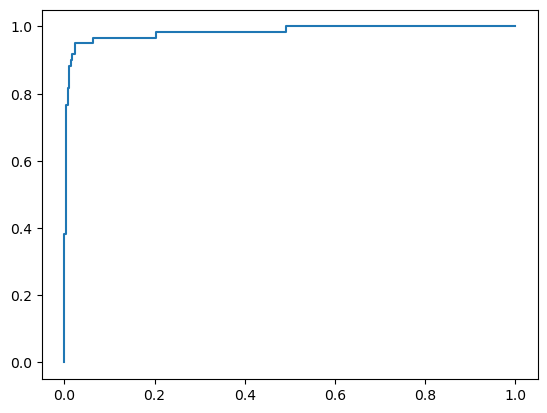

In [88]:
plt.plot(fpr, tpr)

In [76]:
yscores.shape, Ytest.shape

((450,), (450,))

In [89]:
model2 = LogisticRegressionCV(max_iter=500).fit(X, Y)

/Users/wltrimbl/miniconda3/envs/scipy/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wltrimbl/miniconda3/envs/scipy/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [84]:
X.shape, Y.shape

((5124, 300), (5124,))

In [90]:
yscores_embeddingCV = model2.predict_proba(XTEST)[:,1]
fpr2, tpr2, thresholds2 = roc_curve ( Ytest.values, yscores_embeddingCV)

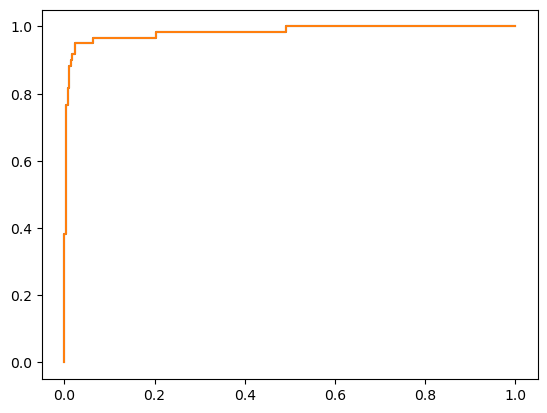

In [91]:
plt.plot(fpr, tpr, label="Logistic (C=1)/ embeddings")
plt.plot(fpr2, tpr2, label="Logistic CV/embeddings")

In [94]:
fpr[10:20], fpr2[10:20], fpr.shape

(array([0.01025641, 0.01538462, 0.01538462, 0.01794872, 0.01794872,
        0.02307692, 0.02307692, 0.05897436, 0.06410256, 0.06410256]),
 array([0.01025641, 0.01538462, 0.01538462, 0.01794872, 0.01794872,
        0.02307692, 0.02307692, 0.05897436, 0.06410256, 0.06410256]),
 (30,))

In [95]:
from sklearn.svm import SVC

In [105]:
svc = SVC(probability=True).fit(X, Y)

In [106]:
svc.score(XTEST, Ytest)

0.9822222222222222

In [113]:
yscores_svc = svc.predict_proba(XTEST)[:,1]
fpr3, tpr3, thresholds3 = roc_curve ( Ytest.values, yscores_svc)

(0.5, 1.0)

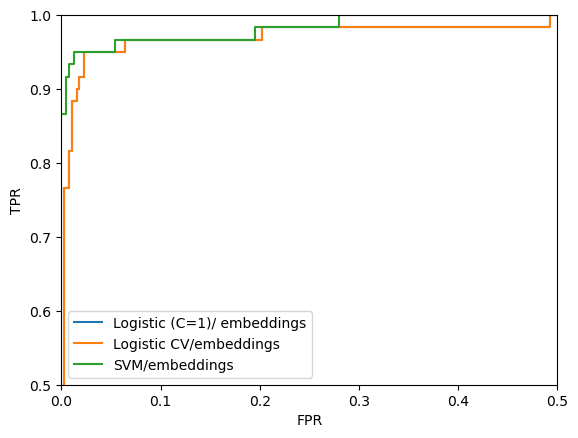

In [121]:
plt.plot(fpr, tpr, label="Logistic (C=1)/ embeddings")
plt.plot(fpr2, tpr2, label="Logistic CV/embeddings")
plt.plot(fpr3, tpr3, label="SVM/embeddings")
plt.legend(); plt.xlabel("FPR"), plt.ylabel("TPR")
plt.xlim(0, 0.5); plt.ylim(0.5,1)

In [129]:
# Create two dataframes.. 
s1 = spam_train.query("label == 'ham'")
s2 = spam_train.query("label == 'spam'")
# Create two giant strings... 
s1text = s1.text.str.cat()
s2text = s2.text.str.cat()
# tokenize the strings (proably split on whitespace)
tok1 = nltk.word_tokenize(s1text)
tok2 = nltk.word_tokenize(s2text)
# And create frequency distribution objects.
d1 = nltk.FreqDist(tok1)
d2 = nltk.FreqDist(tok2)

In [130]:
DEBUG=0
def score(utterance):
    cumscore = 0
    NHAM = d1.N()
    NSPAM = d2.N()
    MAXSCORE = np.log(100) / np.log(2)
    MINSCORE_HAM = np.log( 0.1 / d1.N() ) / np.log(2)
    MINSCORE_SPAM = np.log( 0.1 / d2.N() ) / np.log(2)

    for token in nltk.word_tokenize(utterance):
        partialscore=0  # Catchall if a word has too few instances
        if d1[token] != 0 and d2[token] != 0 and (d1[token]+d2[token]):
            partialscore = (np.log(d1[token]) - np.log(NHAM) -
                            np.log(d2[token])  + np.log(NSPAM))/np.log(2) 
            partialscore = np.minimum(MAXSCORE, np.maximum(-MAXSCORE, partialscore))
            if DEBUG: 
                print(partialscore, d1[token], d2[token])
        if d1[token] == 0 and d2[token] > 0:
            partialscore = -MAXSCORE
        if d2[token] == 0 and d1[token]> 0 :
            partialscore = MAXSCORE
        if d2[token] == 0 and d1[token] == 0 :
            partialscore = MINSCORE_HAM - MINSCORE_SPAM 
        cumscore = cumscore + partialscore
    return(cumscore)

In [131]:
score("free")

-2.2978966013445334

In [136]:
nbc_scores = Xtest.apply(score)

(array([2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 2., 3., 1., 2., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 3., 1., 0., 0., 1., 1., 0., 2., 2., 0.,
        1., 2., 0., 1., 0., 0., 3., 0., 1., 1., 1., 1., 2., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 3., 1.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1.]),
 array([-126.24499951, -124.51088929, -122.77677907, -121.04266885,
        -119.30855863, -117.57444841, -115.84033819, -114.10622797,
        -112.37211775, -110.63800753, -108.90389731, -107.16978708,
        -105.43567686, -103.70156664, -101.96745642, -100.2333462 ,
         -98.49923598,  -96.76512576,  -95.03101554,  -93.29690532,
         -91.5627951 ,  -89.82868488,  -88.09457465,  -86.36046443,
         -84.62635421,  -82.89224399,  -81.15813377,  -79.42402355,
         -77.68991333,  -75.95580311,  -74.22169289,  -72.48758267,
      

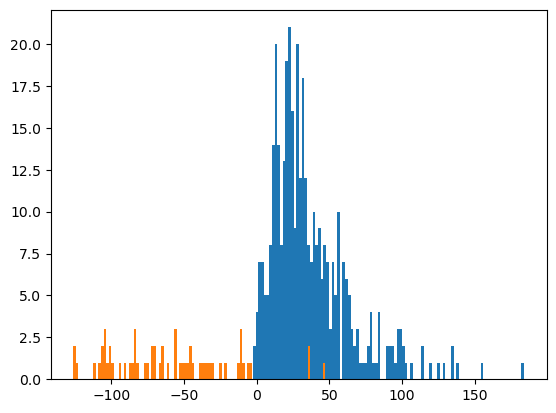

In [155]:
plt.hist(nbc_scores[Ytest==0], bins=100)
plt.hist(nbc_scores[Ytest==1], bins=100)

In [161]:
thresholds_nbc = np.arange(-100, 200, 1)
fprs = []
tprs = []
for thresh in thresholds_nbc:
    tpr = np.sum ( (nbc_scores < thresh ) *  (Ytest == 1)) / np.sum (Ytest==1)
    fpr = np.sum ( (nbc_scores < thresh ) *  (Ytest == 0)) / np.sum (Ytest==0) 
    fprs.append(fpr)
    tprs.append(tpr)
    print(thresh, tpr, fpr)
tpr=np.array(tprs)
fpr=np.array(fprs)

-100 0.21666666666666667 0.0
-99 0.23333333333333334 0.0
-98 0.23333333333333334 0.0
-97 0.23333333333333334 0.0
-96 0.23333333333333334 0.0
-95 0.23333333333333334 0.0
-94 0.23333333333333334 0.0
-93 0.25 0.0
-92 0.25 0.0
-91 0.26666666666666666 0.0
-90 0.26666666666666666 0.0
-89 0.26666666666666666 0.0
-88 0.26666666666666666 0.0
-87 0.2833333333333333 0.0
-86 0.3 0.0
-85 0.3 0.0
-84 0.31666666666666665 0.0
-83 0.35 0.0
-82 0.36666666666666664 0.0
-81 0.36666666666666664 0.0
-80 0.36666666666666664 0.0
-79 0.36666666666666664 0.0
-78 0.36666666666666664 0.0
-77 0.36666666666666664 0.0
-76 0.38333333333333336 0.0
-75 0.38333333333333336 0.0
-74 0.4 0.0
-73 0.4 0.0
-72 0.43333333333333335 0.0
-71 0.43333333333333335 0.0
-70 0.4666666666666667 0.0
-69 0.4666666666666667 0.0
-68 0.4666666666666667 0.0
-67 0.4666666666666667 0.0
-66 0.48333333333333334 0.0
-65 0.48333333333333334 0.0
-64 0.5166666666666667 0.0
-63 0.5166666666666667 0.0
-62 0.5166666666666667 0.0
-61 0.5166666666666667 0

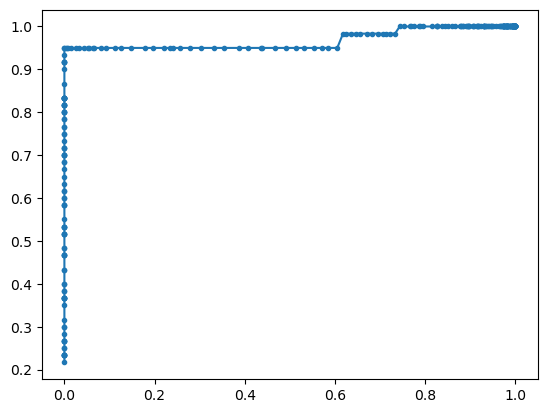

In [162]:
plt.plot(fpr, tpr, '.-')

Text(0.5, 1.0, 'ROC for three different spamclassifiers')

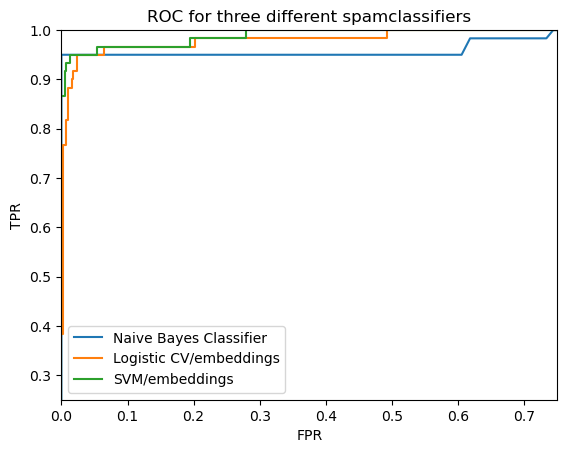

In [165]:
plt.plot(fpr, tpr, label="Naive Bayes Classifier")
plt.plot(fpr2, tpr2, label="Logistic CV/embeddings")
plt.plot(fpr3, tpr3, label="SVM/embeddings")
plt.legend(); plt.xlabel("FPR"), plt.ylabel("TPR")
plt.xlim(0, 0.75); plt.ylim(0.25,1)
plt.title("ROC for three different spamclassifiers")